Datathon - Machine Learning Engineering - Grupo 34 - Pos Tech FIAP - 22/05/2025

Applicants

In [1]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from statsmodels.tools.tools import add_constant
from mlflow.models import infer_signature
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import numpy as np
import warnings
import requests
import mlflow
import joblib
import json
import os


In [2]:
# mlflow server --host localhost --port 9000 # NECESS√ÅRIO RODAR PARA INICIAR O SERVIDOR.
"""
mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlruns --host localhost --port 9000
"""
mlflow.set_tracking_uri(uri="http://localhost:5000")

# Create a new MLflow Experiment
mlflow.set_experiment("MLflow Recrutamento & sele√ß√£o")

<Experiment: artifact_location='s3://mlflow-tc/1', creation_time=1746145721662, experiment_id='1', last_update_time=1746145721662, lifecycle_stage='active', name='MLflow Recrutamento & sele√ß√£o', tags={}>

In [3]:
def baixar_arquivo_com_get(url, nome_arquivo_destino):
    """Baixa um arquivo da URL fornecida com uma barra de progresso."""
    
    if not os.path.exists("files"):
        print("Cliendo pasta files")
        os.makedirs("files")
    
    try:
        resposta = requests.get(url, stream=True)
        resposta.raise_for_status()
        total_size_in_bytes = int(resposta.headers.get('content-length', 0))
        block_size = 1024  # 1 Kibibyte

        with tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True, desc=nome_arquivo_destino) as progress_bar:
            with open("files/" + nome_arquivo_destino, 'wb') as arquivo_destino:
                for chunk in resposta.iter_content(chunk_size=block_size):
                    arquivo_destino.write(chunk)
                    progress_bar.update(len(chunk))

        print(f"\nArquivo baixado com sucesso como: {nome_arquivo_destino}")

    except requests.exceptions.RequestException as e:
        print(f"Erro ao baixar o arquivo: {e}")
    except Exception as e:
        print(f"Ocorreu um erro: {e}")

In [4]:
def processar_json(caminho_arquivo, key):
    with open(caminho_arquivo, 'r', encoding='utf-8') as f:
        data:dict = json.load(f)
    
    registros:list = []
    for id_profissional, dados in data.items():
        registro = {key: id_profissional}  # Adiciona o ID como coluna
        
        # Percorre todas as se√ß√µes do JSON
        for secao, valores in dados.items():
            if isinstance(valores, dict):  # Se a se√ß√£o tiver subitens, adiciona normalmente
                registro.update(valores)
            else:  # Se for um valor √∫nico (ex: cv_pt, cv_en, cargo_atual vazio)
                registro[secao] = valores
        
        registros.append(registro)

    return pd.DataFrame(registros)

# Nome do arquivo JSON
caminho_arquivo = os.path.join(os.getcwd(), "files", "applicants.json")

# N√£o existe local obtem do S3.
if not os.path.exists(caminho_arquivo):
    baixar_arquivo_com_get("https://tc-f5-files.s3.us-east-1.amazonaws.com/applicants.json", "applicants.json")

if os.path.exists(caminho_arquivo):
    applicants:pd = processar_json(caminho_arquivo, "id_candidato")
    print("Arquivo encontrado e carregado com sucesso!")
else:
    print("Arquivo n√£o encontrado.")
    
applicants.head()

Arquivo encontrado e carregado com sucesso!


id_candidato telefone_recado         telefone        objetivo_profissional  \
0        31000                  (11) 97048-2708                                
1        31001                  (11) 93723-4396      Analista Administrativo   
2        31002                  (11) 92399-9824  Administrativo | Financeiro   
3        31003                  (11) 98100-1727          √Årea administrativa   
4        31004                  (11) 92517-2678                                

          data_criacao       inserido_por                              email  \
0  10-11-2021 07:29:49       Luna Correia       carolina_aparecida@gmail.com   
1  10-11-2021 08:56:16      Laura Pacheco           eduardo_rios@hotmail.com   
2  10-11-2021 09:01:00      Laura Pacheco  pedro_henrique_carvalho@gmail.com   
3  10-11-2021 09:08:13      Laura Pacheco         thiago_barbosa@hotmail.com   
4  10-11-2021 09:18:46  Maria Clara Pires        diogo_das_neves@hotmail.com   

                  local sabendo_de_nos_por     data_atualizacao  ...  \
0                                           10-11-2021 07:29:49  ...   
1  S√£o Paulo, S√£o Paulo             Outros  11-11-2021 11:10:31  ...   
2  S√£o Paulo, S√£o Paulo            An√∫ncio  10-11-2021 11:42:36  ...   
3  S√£o Paulo, S√£o Paulo   Site de Empregos  10-11-2021 16:04:51  ...   
4                                           10-11-2021 09:22:03  ...   

  id_ibrati email_corporativo cargo_atual projeto_atual cliente unidade  \
0       NaN               NaN         NaN           NaN     NaN     NaN   
1       NaN               NaN         NaN           NaN     NaN     NaN   
2       NaN               NaN         NaN           NaN     NaN     NaN   
3       NaN               NaN         NaN           NaN     NaN     NaN   
4       NaN               NaN         NaN           NaN     NaN     NaN   

  data_admissao data_ultima_promocao nome_superior_imediato  \
0           NaN                  NaN                    NaN   
1           NaN                  NaN                    NaN   
2           NaN                  NaN                    NaN   
3           NaN                  NaN                    NaN   
4           NaN                  NaN                    NaN   

  email_superior_imediato  
0                     NaN  
1                     NaN  
2                     NaN  
3                     NaN  
4                     NaN  

[5 rows x 55 columns]

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
applicants.shape

(42482, 55)

Vagas

In [7]:
nome_arquivo = "vagas.json"
caminho_arquivo = os.path.join(os.getcwd(), "files", "vagas.json")

# N√£o existe local obtem do S3.
if not os.path.exists(caminho_arquivo):
    baixar_arquivo_com_get("https://tc-f5-files.s3.us-east-1.amazonaws.com/vagas.json", "vagas.json")
    
if os.path.exists(caminho_arquivo):
    vagas = processar_json(caminho_arquivo, key="id_vaga")
    print("Arquivo encontrado e carregado com sucesso!")
else:
    print("Arquivo n√£o encontrado.")

vagas.json: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 38.7M/38.7M [00:02<00:00, 17.2MiB/s]



Arquivo baixado com sucesso como: vagas.json
Arquivo encontrado e carregado com sucesso!


In [8]:
pd.set_option('display.max_columns', None)

In [9]:
vagas.shape

(14081, 45)

Prospects

In [10]:
def processar_json_para_dataframe(json_data:dict):
    dados:list = []

    for id_vaga, vaga_info in json_data.items():
        vaga_info:dict
        
        titulo = vaga_info.get("titulo", "")
        modalidade = vaga_info.get("modalidade", "")

        # Se houver uma lista dentro do JSON, criamos m√∫ltiplas linhas
        if "prospects" in vaga_info:
            for prospect in vaga_info["prospects"]:
                linha = {"id_vaga": id_vaga, "titulo": titulo, "modalidade": modalidade}
                linha.update(prospect)  # Adiciona os dados de prospects como colunas
                dados.append(linha)
        else:
            dados.append({"id_vaga": id_vaga, "titulo": titulo, "modalidade": modalidade})

    return pd.DataFrame(dados)

# Caminho do arquivo JSON
caminho_arquivo = os.path.join(os.getcwd(), "files", "prospects.json")

# N√£o existe local obtem do S3.
if not os.path.exists(caminho_arquivo):
    baixar_arquivo_com_get("https://tc-f5-files.s3.us-east-1.amazonaws.com/prospects.json", "prospects.json")
    
    
if os.path.exists(caminho_arquivo):
    # Carregar JSON
    with open(caminho_arquivo, "r", encoding="utf-8") as file:
        json_data = json.load(file)

    # Converter para DataFrame
    prospects = processar_json_para_dataframe(json_data)

prospects.json: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 21.5M/21.5M [00:01<00:00, 14.3MiB/s]



Arquivo baixado com sucesso como: prospects.json


In [11]:
pd.set_option('display.max_columns', None)
# Renomeando a coluna 'codigo' para 'id_candidato'
prospects.rename(columns={'codigo': 'id_candidato', 'cidade': 'cidade_vaga'}, inplace=True)

In [12]:
prospects.shape

(53759, 10)

An√°lise Explorat√≥ria de Dados

In [13]:
# Unir Prospects com Applicants (vaga -> candidato)
prospects_applicants = prospects.merge(applicants, left_on="id_candidato", right_on="id_candidato", how="left")

# Unir com Vagas (vaga -> detalhes da vaga)
df = prospects_applicants.merge(vagas, left_on="id_vaga", right_on="id_vaga", how="left")

In [14]:
df.shape

(53759, 108)

In [15]:
# Remover 'nome_y'
df = df.drop(columns=['nome_y'], errors='ignore')

# Renomear colunas
df = df.rename(columns=lambda col: col.replace('_x', '_candidato').replace('_y', '_vaga'))
df = df.rename(columns={"local": "cidade_candidato", "cidade": "cidade_vaga", "nivel profissional": "nivel_profissional_vaga", 
                        "areas_atuacao": "areas_atuacao_vaga", "nivel_profissional": "nivel_profissional_candidato",
                        "cursos": "cursos_candidato", "remuneracao": "remuneracao_candidato"})

In [16]:
# Separando as colunas a serem usadas

df = df[['situacao_candidado','recrutador','cidade_candidato',
                'data_nascimento','sexo','estado_civil','pcd','remuneracao_candidato','nivel_profissional_candidato',
                'nivel_academico_candidato',
                'nivel_ingles_candidato','nivel_espanhol_candidato','cursos_candidato',
                'cliente_vaga','tipo_contratacao',
                'prioridade_vaga','origem_vaga','cidade_vaga',
                'nivel_profissional_vaga','nivel_academico_vaga','nivel_ingles_vaga','nivel_espanhol_vaga',
                'areas_atuacao_vaga','ultima_atualizacao']]

In [17]:
df.shape

(53759, 24)

In [18]:
print(f'Linhas duplicadas: {df.duplicated().sum()}')

Linhas duplicadas: 8274


In [19]:
df.drop_duplicates(inplace=True)  # Remove duplicatas

In [20]:
# Convertendo as colunas para datetime, tratando erros
df[['data_nascimento','ultima_atualizacao']] = df[
    ['data_nascimento','ultima_atualizacao']].apply(
    lambda col: pd.to_datetime(col, errors='coerce', format='%d-%m-%Y'))

In [21]:
# Extraindo apenas os n√∫meros e convertendo para inteiro
df['remuneracao_candidato'] = (
    df['remuneracao_candidato']
    .str.replace(r'[^\d,.-]', '', regex=True)  # Remove tudo que n√£o for n√∫mero, v√≠rgula, ponto ou h√≠fen
    .str.replace(',', '.', regex=False)  # Substitui v√≠rgula por ponto
    .str.extract(r'(-?\d+\.?\d*)')  # Captura o primeiro n√∫mero v√°lido
    .astype(float)  # Converte para float primeiro
    .fillna(0)  # Substitui NaN por 0 (opcional)
    .astype(int)  # Converte para inteiro
)

In [22]:
# Calculando a idade (diferenca entre anos)
df['idade'] = df['ultima_atualizacao'].dt.year - df['data_nascimento'].dt.year
# Removendo as colunas 'data_nascimento' e 'ultima_atualizacao'
df = df.drop(columns=['data_nascimento', 'ultima_atualizacao'])

In [23]:
df.describe(include="all")

situacao_candidado            recrutador cidade_candidato   sexo  \
count               45485                 45485            39281  39281   
unique                 21                    77              615      3   
top              Prospect  Srta. Bella Ferreira                           
freq                15430                  4462            18802  26683   
mean                  NaN                   NaN              NaN    NaN   
std                   NaN                   NaN              NaN    NaN   
min                   NaN                   NaN              NaN    NaN   
25%                   NaN                   NaN              NaN    NaN   
50%                   NaN                   NaN              NaN    NaN   
75%                   NaN                   NaN              NaN    NaN   
max                   NaN                   NaN              NaN    NaN   

       estado_civil    pcd  remuneracao_candidato  \
count         39281  39281           4.548500e+04   
unique            7      3                    NaN   
top                                           NaN   
freq          28605  28974                    NaN   
mean            NaN    NaN           1.996147e+05   
std             NaN    NaN           1.455928e+07   
min             NaN    NaN          -4.700000e+03   
25%             NaN    NaN           0.000000e+00   
50%             NaN    NaN           0.000000e+00   
75%             NaN    NaN           0.000000e+00   
max             NaN    NaN           1.400013e+09   

       nivel_profissional_candidato nivel_academico_candidato  \
count                         39281                     39281   
unique                           10                        22   
top                                                             
freq                          38988                     27564   
mean                            NaN                       NaN   
std                             NaN                       NaN   
min                             NaN                       NaN   
25%                             NaN                       NaN   
50%                             NaN                       NaN   
75%                             NaN                       NaN   
max                             NaN                       NaN   

       nivel_ingles_candidato nivel_espanhol_candidato cursos_candidato  \
count                   39281                    39281            10901   
unique                      6                        6              127   
top                                                                       
freq                    28092                    28392             1065   
mean                      NaN                      NaN              NaN   
std                       NaN                      NaN              NaN   
min                       NaN                      NaN              NaN   
25%                       NaN                      NaN              NaN   
50%                       NaN                      NaN              NaN   
75%                       NaN                      NaN              NaN   
max                       NaN                      NaN              NaN   

        cliente_vaga tipo_contratacao                     prioridade_vaga  \
count          45462            45462                               45462   
unique           111               40                                   4   
top     Morrison Ltd      PJ/Aut√¥nomo  Alta: Alta complexidade 3 a 5 dias   
freq            6274            15694                               30139   
mean             NaN              NaN                                 NaN   
std              NaN              NaN                                 NaN   
min              NaN              NaN                                 NaN   
25%              NaN              NaN                                 NaN   
50%              NaN              NaN                                 NaN   
75%             

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45485 entries, 0 to 53758
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   situacao_candidado            45485 non-null  object 
 1   recrutador                    45485 non-null  object 
 2   cidade_candidato              39281 non-null  object 
 3   sexo                          39281 non-null  object 
 4   estado_civil                  39281 non-null  object 
 5   pcd                           39281 non-null  object 
 6   remuneracao_candidato         45485 non-null  int32  
 7   nivel_profissional_candidato  39281 non-null  object 
 8   nivel_academico_candidato     39281 non-null  object 
 9   nivel_ingles_candidato        39281 non-null  object 
 10  nivel_espanhol_candidato      39281 non-null  object 
 11  cursos_candidato              10901 non-null  object 
 12  cliente_vaga                  45462 non-null  object 
 13  tipo_c

In [25]:
df.head()

situacao_candidado         recrutador  \
0  Encaminhado ao Requisitante  Ana L√≠via Moreira   
1  Encaminhado ao Requisitante  Ana L√≠via Moreira   
2     Contratado pela Decision   Juliana Cassiano   
3  Encaminhado ao Requisitante   Juliana Cassiano   
4     Contratado pela Decision      Stella Vieira   

                 cidade_candidato       sexo estado_civil  pcd  \
0                                                                
1  Rio de Janeiro, Rio de Janeiro  Masculino     Solteiro  N√£o   
2            S√£o Paulo, S√£o Paulo  Masculino       Casado  N√£o   
3                                                                
4                                                                

   remuneracao_candidato nivel_profissional_candidato  \
0                      0                                
1                   5600                                
2                     15                                
3                      0                                
4                      0                                

  nivel_academico_candidato nivel_ingles_candidato nivel_espanhol_candidato  \
0                                                                             
1  Ensino Superior Completo          Intermedi√°rio                   B√°sico   
2  Ensino Superior Completo               Avan√ßado            Intermedi√°rio   
3                                                                             
4                                                                             

           cursos_candidato              cliente_vaga tipo_contratacao  \
0                       NaN  Morris, Moran and Dodson      PJ/Aut√¥nomo   
1                            Morris, Moran and Dodson      PJ/Aut√¥nomo   
2  Tecnologia da Informa√ß√£o         Gonzalez and Sons      PJ/Aut√¥nomo   
3                       NaN         Gonzalez and Sons      PJ/Aut√¥nomo   
4                       NaN              Barnes-Woods      PJ/Aut√¥nomo   

                         prioridade_vaga   origem_vaga     cidade_vaga  \
0                                                       Rio de Janeiro   
1                                                       Rio de Janeiro   
2  M√©dia: M√©dia complexidade 6 a 10 dias  Nova Posi√ß√£o       S√£o Paulo   
3  M√©dia: M√©dia complexidade 6 a 10 dias  Nova Posi√ß√£o       S√£o Paulo   
4  M√©dia: M√©dia complexidade 6 a 10 dias  Nova Posi√ß√£o       S√£o Paulo   

  nivel_profissional_vaga      nivel_academico_vaga nivel_ingles_vaga  \
0                   Pleno  Ensino Superior Completo            Nenhum   
1                   Pleno  Ensino Superior Completo            Nenhum   
2                  S√™nior     Ensino M√©dio Completo            Nenhum   
3                  S√™nior     Ensino M√©dio Completo            Nenhum   
4                  S√™nior     Ensino M√©dio Completo           T√©cnico   

  nivel_espanhol_vaga                    areas_atuacao_vaga  idade  
0              Nenhum     TI - Desenvolvimento/Programa√ß√£o-    NaN  
1              Nenhum     TI - Desenvolvimento/Programa√ß√£o-   48.0  
2              Nenhum  Gest√£o e Aloca√ß√£o de Recursos de TI-   48.0  
3              Nenhum  Gest√£o e Aloca√ß√£o de Recursos de TI-    NaN  
4             Fluente  Gest√£o e Aloca√ß√£o de Recursos de TI-    NaN

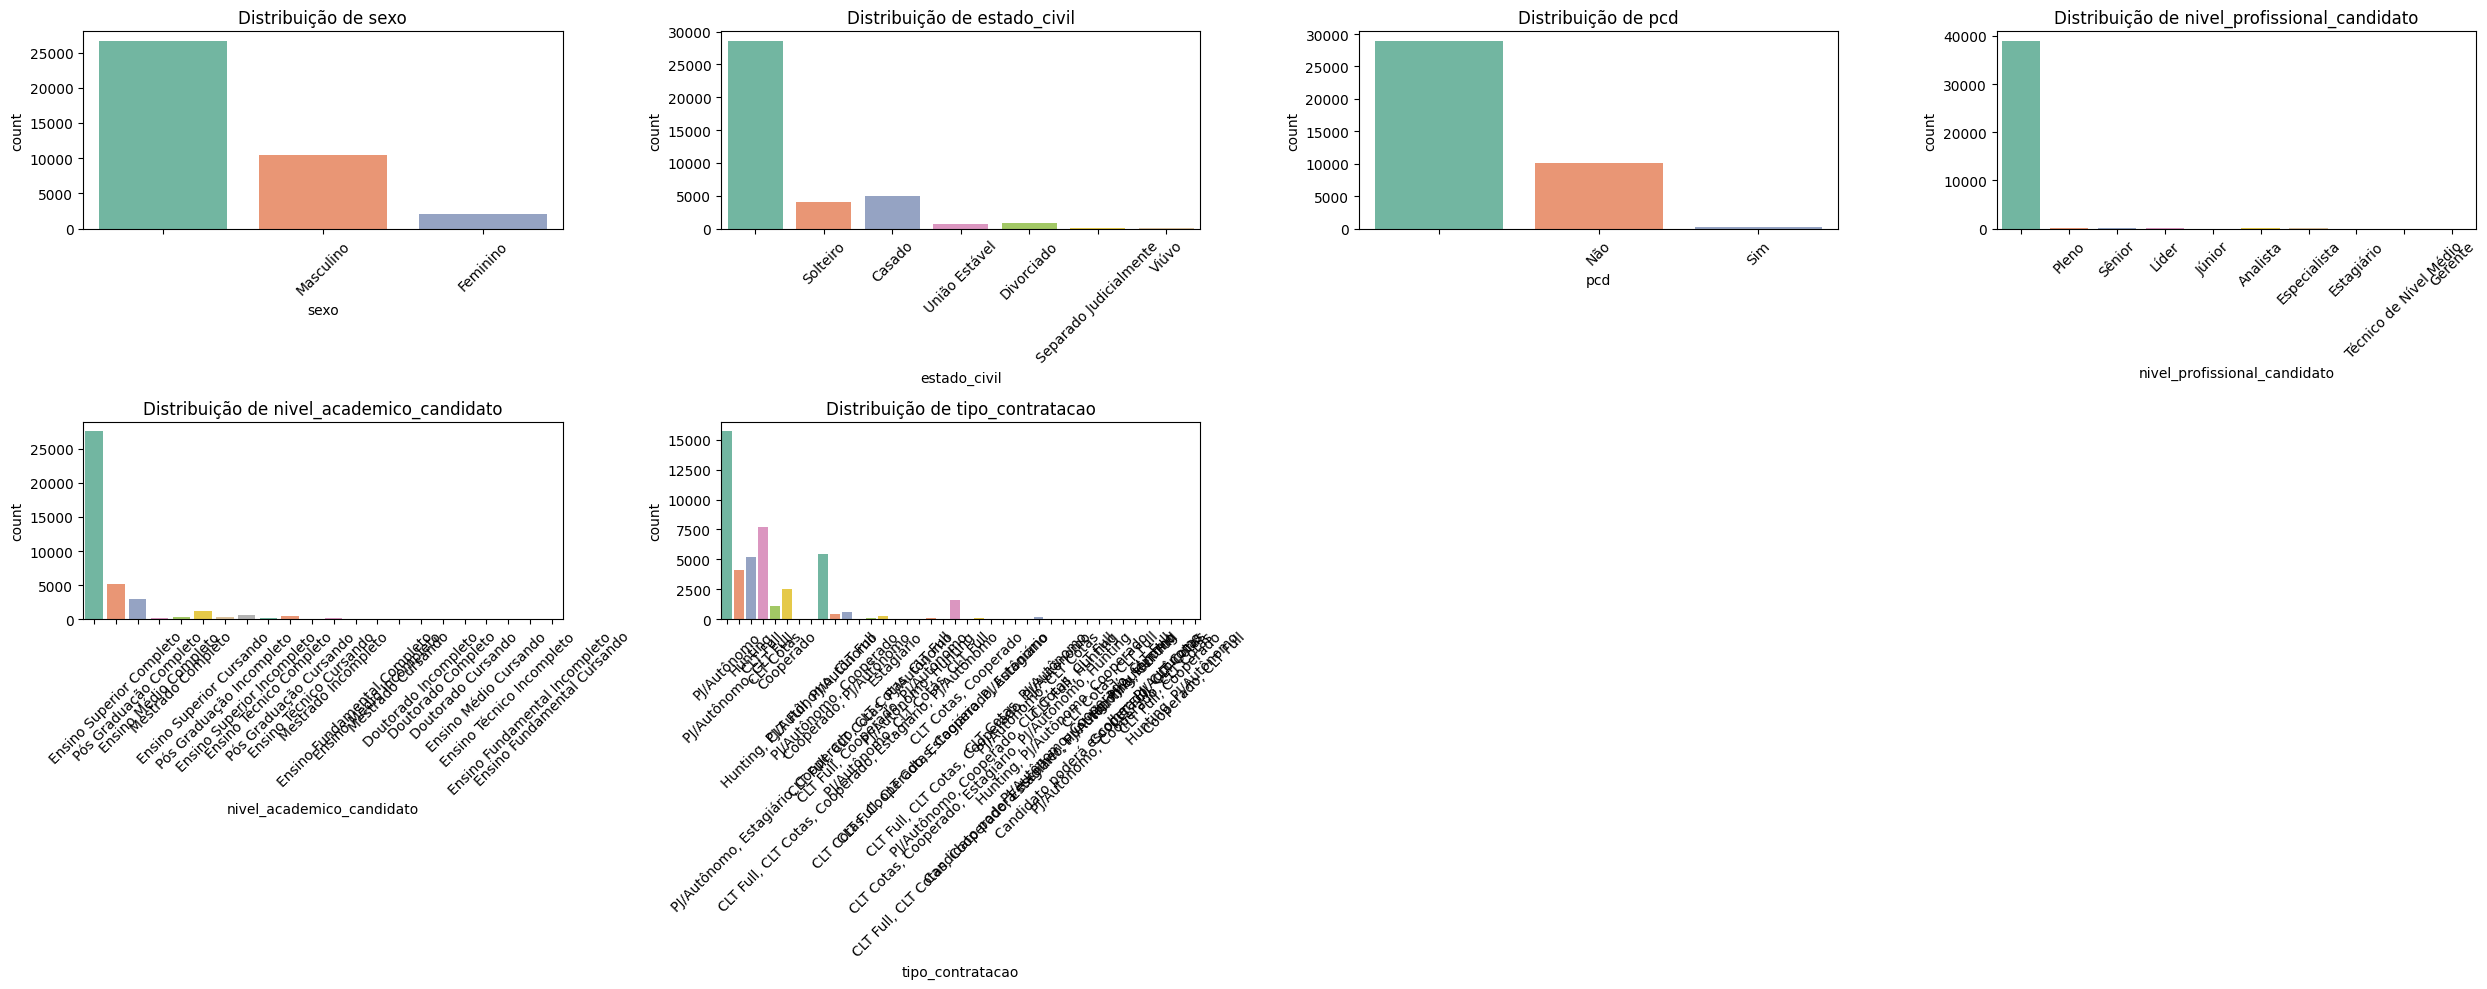

In [26]:
warnings.filterwarnings("ignore")

# Gr√°ficos de barras para vari√°veis categ√≥ricas
categorical_columns = ['sexo', 'estado_civil', 'pcd', 'nivel_profissional_candidato', 'nivel_academico_candidato', 'tipo_contratacao']

plt.figure(figsize=(25, 10))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(2, 4, i)
    sns.countplot(x=df[col], palette='Set2')
    plt.title(f'Distribui√ß√£o de {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

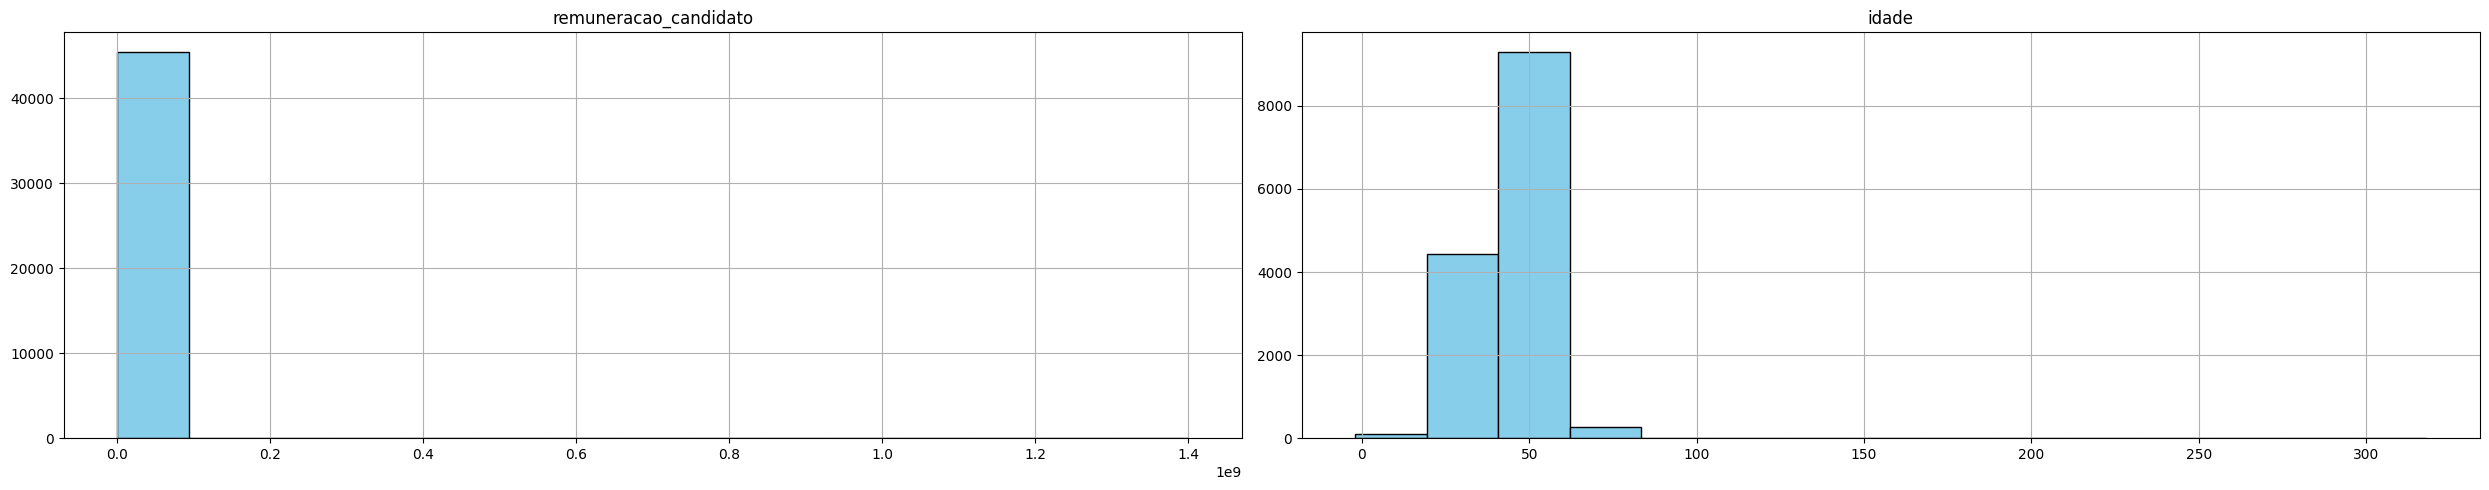

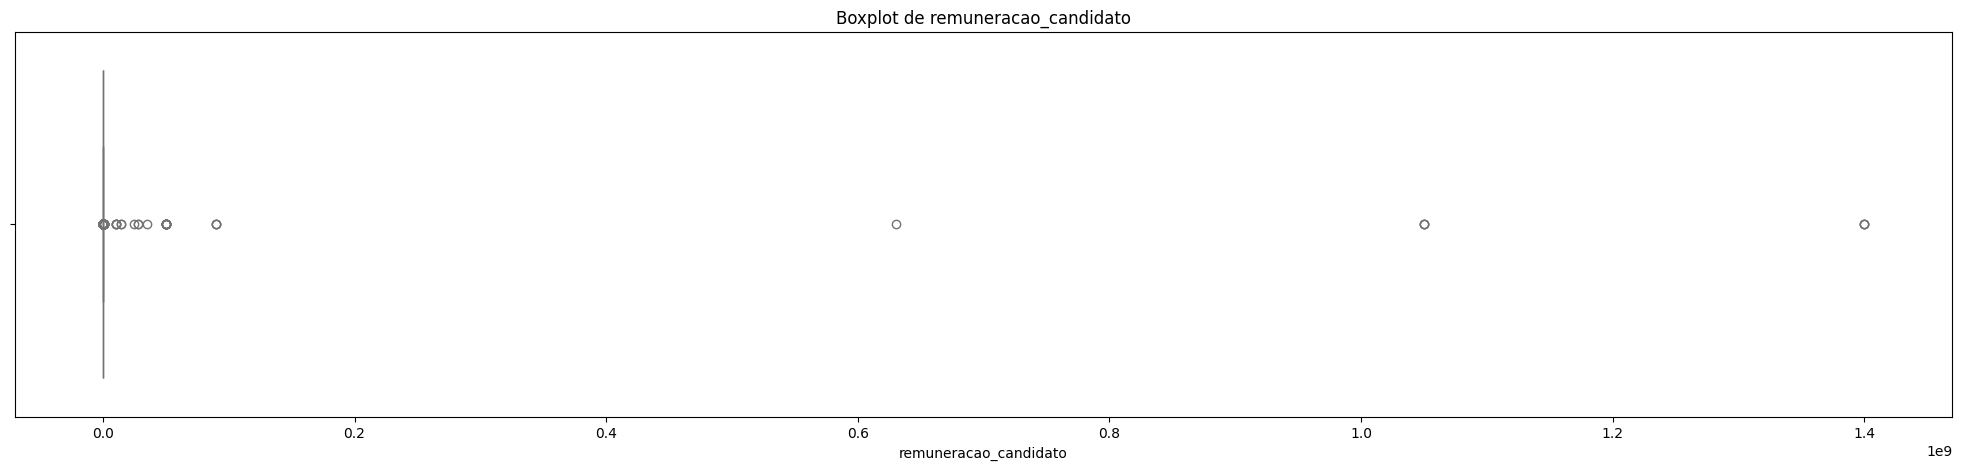

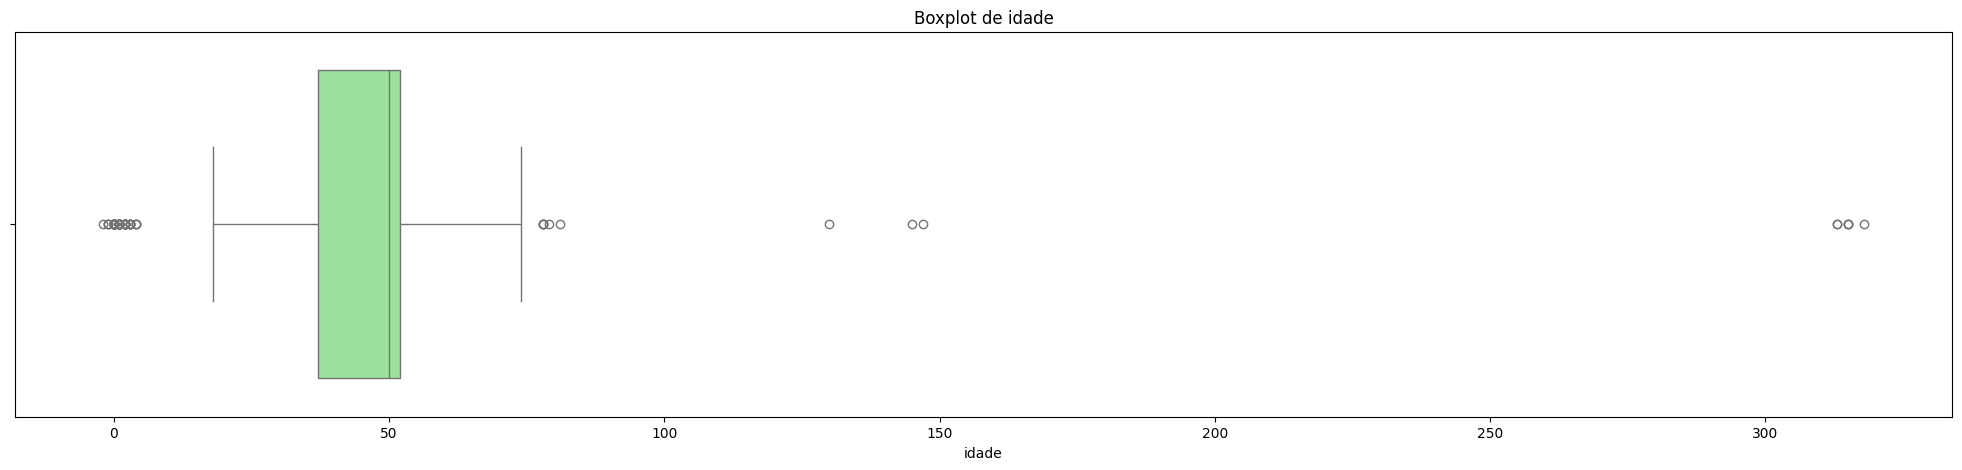

In [27]:
# Histograma para vari√°veis num√©ricas
numeric_columns = ['remuneracao_candidato', 'idade']
df[numeric_columns].hist(bins=15, figsize=(25, 5), color='skyblue', edgecolor='black')
plt.tight_layout()
plt.show()

# Boxplot para detectar outliers
for col in numeric_columns:
    plt.figure(figsize=(25, 5))
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f'Boxplot de {col}')
    plt.show()

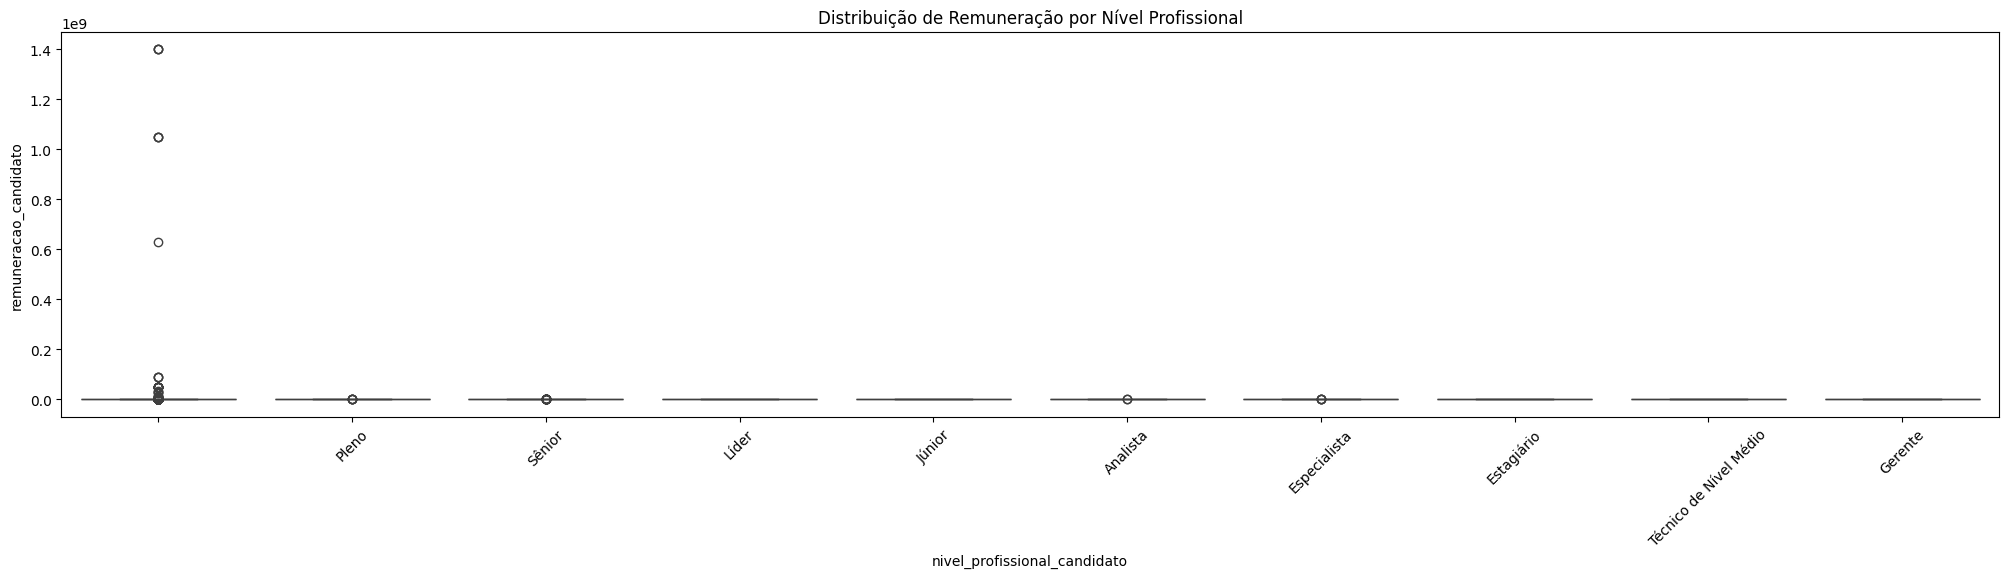

In [28]:
# Exemplo para 'remuneracao' e 'nivel_profissional'
plt.figure(figsize=(25, 5))
sns.boxplot(x='nivel_profissional_candidato', y='remuneracao_candidato', data=df)
plt.title('Distribui√ß√£o de Remunera√ß√£o por N√≠vel Profissional')
plt.xticks(rotation=45)
plt.show()

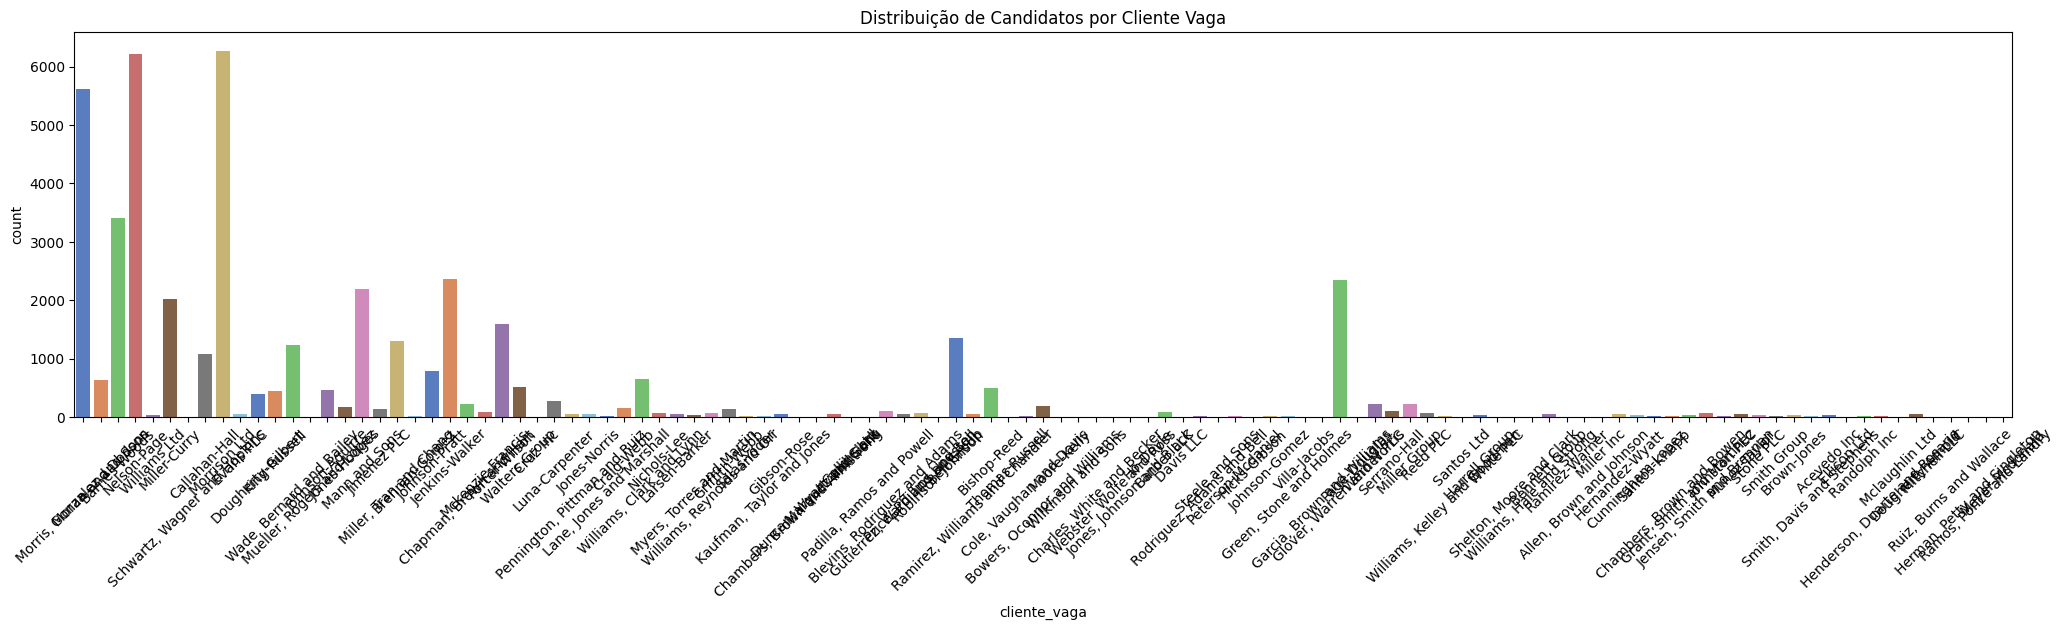

In [29]:
# Distribui√ß√£o de candidatos por tipo de vaga
plt.figure(figsize=(25, 5))
sns.countplot(x='cliente_vaga', data=df, palette='muted')
plt.title('Distribui√ß√£o de Candidatos por Cliente Vaga')
plt.xticks(rotation=45)
plt.show()

In [30]:
# Visualizando valores extremos
df[df['idade'] < 18].head(1)  # Se houver idades menores que 18, pode ser um erro

situacao_candidado   recrutador            cidade_candidato       sexo  \
41           Prospect  Ana Camargo  Bras√≠lia, Distrito Federal  Masculino   

   estado_civil  pcd  remuneracao_candidato nivel_profissional_candidato  \
41     Solteiro  N√£o                  10300                                

   nivel_academico_candidato nivel_ingles_candidato nivel_espanhol_candidato  \
41  Ensino Superior Completo          Intermedi√°rio                   B√°sico   

          cursos_candidato       cliente_vaga tipo_contratacao  \
41  Sistemas de Informa√ß√£o  Gonzalez and Sons          Hunting   

                          prioridade_vaga   origem_vaga cidade_vaga  \
41  M√©dia: M√©dia complexidade 6 a 10 dias  Nova Posi√ß√£o   S√£o Paulo   

   nivel_profissional_vaga   nivel_academico_vaga nivel_ingles_vaga  \
41                  S√™nior  Ensino M√©dio Completo            Nenhum   

   nivel_espanhol_vaga         areas_atuacao_vaga  idade  
41              Nenhum  Financeira/Controladoria-    0.0

In [31]:
# Visualizando valores extremos
df[df['remuneracao_candidato'] > 1000000].head(1)  # Verificando se h√° remunera√ß√µes extremamente altas

situacao_candidado      recrutador        cidade_candidato       sexo  \
4688           Prospect  Yasmin da Rosa  Araguari, Minas Gerais  Masculino   

     estado_civil  pcd  remuneracao_candidato nivel_profissional_candidato  \
4688       Casado  N√£o               50001600                                

     nivel_academico_candidato nivel_ingles_candidato  \
4688  Ensino Superior Completo          Intermedi√°rio   

     nivel_espanhol_candidato                    cursos_candidato  \
4688                   B√°sico  Engenharia de Controle e Automa√ß√£o   

        cliente_vaga tipo_contratacao                     prioridade_vaga  \
4688  Jenkins-Walker          Hunting  Alta: Alta complexidade 3 a 5 dias   

     origem_vaga   cidade_vaga nivel_profissional_vaga  \
4688              S√£o Leopoldo                  S√™nior   

          nivel_academico_vaga nivel_ingles_vaga nivel_espanhol_vaga  \
4688  Ensino Superior Completo          Avan√ßado            Avan√ßado   

        areas_atuacao_vaga  idade  
4688  TI - Infraestrutura-   49.0

Feature Engineering e pr√©-processamento

In [32]:
valores_positivos = ['Contratado pela Decision', 'Aprovado', 'Contratado como Hunting', 'Proposta Aceita']
df['situacao_candidado'] = df['situacao_candidado'].isin(valores_positivos).astype(int)

In [33]:
df['situacao_candidado'].value_counts()

situacao_candidado
0    42543
1     2942
Name: count, dtype: int64

In [34]:
df.head()

situacao_candidado         recrutador                cidade_candidato  \
0                   0  Ana L√≠via Moreira                                   
1                   0  Ana L√≠via Moreira  Rio de Janeiro, Rio de Janeiro   
2                   1   Juliana Cassiano            S√£o Paulo, S√£o Paulo   
3                   0   Juliana Cassiano                                   
4                   1      Stella Vieira                                   

        sexo estado_civil  pcd  remuneracao_candidato  \
0                                                   0   
1  Masculino     Solteiro  N√£o                   5600   
2  Masculino       Casado  N√£o                     15   
3                                                   0   
4                                                   0   

  nivel_profissional_candidato nivel_academico_candidato  \
0                                                          
1                               Ensino Superior Completo   
2                               Ensino Superior Completo   
3                                                          
4                                                          

  nivel_ingles_candidato nivel_espanhol_candidato          cursos_candidato  \
0                                                                       NaN   
1          Intermedi√°rio                   B√°sico                             
2               Avan√ßado            Intermedi√°rio  Tecnologia da Informa√ß√£o   
3                                                                       NaN   
4                                                                       NaN   

               cliente_vaga tipo_contratacao  \
0  Morris, Moran and Dodson      PJ/Aut√¥nomo   
1  Morris, Moran and Dodson      PJ/Aut√¥nomo   
2         Gonzalez and Sons      PJ/Aut√¥nomo   
3         Gonzalez and Sons      PJ/Aut√¥nomo   
4              Barnes-Woods      PJ/Aut√¥nomo   

                         prioridade_vaga   origem_vaga     cidade_vaga  \
0                                                       Rio de Janeiro   
1                                                       Rio de Janeiro   
2  M√©dia: M√©dia complexidade 6 a 10 dias  Nova Posi√ß√£o       S√£o Paulo   
3  M√©dia: M√©dia complexidade 6 a 10 dias  Nova Posi√ß√£o       S√£o Paulo   
4  M√©dia: M√©dia complexidade 6 a 10 dias  Nova Posi√ß√£o       S√£o Paulo   

  nivel_profissional_vaga      nivel_academico_vaga nivel_ingles_vaga  \
0                   Pleno  Ensino Superior Completo            Nenhum   
1                   Pleno  Ensino Superior Completo            Nenhum   
2                  S√™nior     Ensino M√©dio Completo            Nenhum   
3                  S√™nior     Ensino M√©dio Completo            Nenhum   
4                  S√™nior     Ensino M√©dio Completo           T√©cnico   

  nivel_espanhol_vaga                    areas_atuacao_vaga  idade  
0              Nenhum     TI - Desenvolvimento/Programa√ß√£o-    NaN  
1              Nenhum     TI - Desenvolvimento/Programa√ß√£o-   48.0  
2              Nenhum  Gest√£o e Aloca√ß√£o de Recursos de TI-   48.0  
3              Nenhum  Gest√£o e Aloca√ß√£o de Recursos de TI-    NaN  
4             Fluente  Gest√£o e Aloca√ß√£o de Recursos de TI-    NaN

In [35]:
# X: todas as colunas, exceto a vari√°vel target
X = df.drop(columns=["situacao_candidado"])

# y: apenas a vari√°vel target
y = df["situacao_candidado"]

In [36]:
# Remover linhas com qualquer valor NaN
X = X.dropna()
y = y[X.index]  # Manter o mesmo √≠ndice de X

In [37]:
# Label Encoding (Se as categorias forem ordinais, ou seja, possuem uma ordem)
# Supondo que 'coluna_categorica' seja a sua coluna categ√≥rica

le = LabelEncoder()

# Lista das colunas a codificar
colunas_categoricas = ['nivel_profissional_candidato', 'nivel_academico_candidato', 'nivel_ingles_candidato', 
                       'nivel_espanhol_candidato', 'prioridade_vaga', 'nivel_profissional_vaga', 
                       'nivel_academico_vaga', 'nivel_ingles_vaga', 'nivel_espanhol_vaga', 'sexo', 'estado_civil', 'pcd','recrutador', 'cidade_candidato','cursos_candidato','cliente_vaga', 'tipo_contratacao',
                       'origem_vaga', 'cidade_vaga','areas_atuacao_vaga']

# Aplicando o LabelEncoder em cada coluna categ√≥rica
for coluna in colunas_categoricas:
    X[coluna] = le.fit_transform(X[coluna])

In [38]:
df.head()

situacao_candidado         recrutador                cidade_candidato  \
0                   0  Ana L√≠via Moreira                                   
1                   0  Ana L√≠via Moreira  Rio de Janeiro, Rio de Janeiro   
2                   1   Juliana Cassiano            S√£o Paulo, S√£o Paulo   
3                   0   Juliana Cassiano                                   
4                   1      Stella Vieira                                   

        sexo estado_civil  pcd  remuneracao_candidato  \
0                                                   0   
1  Masculino     Solteiro  N√£o                   5600   
2  Masculino       Casado  N√£o                     15   
3                                                   0   
4                                                   0   

  nivel_profissional_candidato nivel_academico_candidato  \
0                                                          
1                               Ensino Superior Completo   
2                               Ensino Superior Completo   
3                                                          
4                                                          

  nivel_ingles_candidato nivel_espanhol_candidato          cursos_candidato  \
0                                                                       NaN   
1          Intermedi√°rio                   B√°sico                             
2               Avan√ßado            Intermedi√°rio  Tecnologia da Informa√ß√£o   
3                                                                       NaN   
4                                                                       NaN   

               cliente_vaga tipo_contratacao  \
0  Morris, Moran and Dodson      PJ/Aut√¥nomo   
1  Morris, Moran and Dodson      PJ/Aut√¥nomo   
2         Gonzalez and Sons      PJ/Aut√¥nomo   
3         Gonzalez and Sons      PJ/Aut√¥nomo   
4              Barnes-Woods      PJ/Aut√¥nomo   

                         prioridade_vaga   origem_vaga     cidade_vaga  \
0                                                       Rio de Janeiro   
1                                                       Rio de Janeiro   
2  M√©dia: M√©dia complexidade 6 a 10 dias  Nova Posi√ß√£o       S√£o Paulo   
3  M√©dia: M√©dia complexidade 6 a 10 dias  Nova Posi√ß√£o       S√£o Paulo   
4  M√©dia: M√©dia complexidade 6 a 10 dias  Nova Posi√ß√£o       S√£o Paulo   

  nivel_profissional_vaga      nivel_academico_vaga nivel_ingles_vaga  \
0                   Pleno  Ensino Superior Completo            Nenhum   
1                   Pleno  Ensino Superior Completo            Nenhum   
2                  S√™nior     Ensino M√©dio Completo            Nenhum   
3                  S√™nior     Ensino M√©dio Completo            Nenhum   
4                  S√™nior     Ensino M√©dio Completo           T√©cnico   

  nivel_espanhol_vaga                    areas_atuacao_vaga  idade  
0              Nenhum     TI - Desenvolvimento/Programa√ß√£o-    NaN  
1              Nenhum     TI - Desenvolvimento/Programa√ß√£o-   48.0  
2              Nenhum  Gest√£o e Aloca√ß√£o de Recursos de TI-   48.0  
3              Nenhum  Gest√£o e Aloca√ß√£o de Recursos de TI-    NaN  
4             Fluente  Gest√£o e Aloca√ß√£o de Recursos de TI-    NaN

In [39]:
# Balanceando a vari√°vel target
X, y = SMOTE().fit_resample(X, y)

In [40]:
# Normaliza√ß√£o/Escalonamento dos dados
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

In [41]:
# Remo√ß√£o de Vari√°veis Irrelevantes
selector = SelectKBest(score_func=f_classif, k=10)  # Escolhe as 10 melhores vari√°veis
X_selected = selector.fit_transform(X_normalized, y)

# Ver quais vari√°veis foram selecionadas
selected_features = X.columns[selector.get_support()]
selected_features

Index(['sexo', 'estado_civil', 'nivel_academico_candidato',
       'nivel_ingles_candidato', 'tipo_contratacao', 'prioridade_vaga',
       'origem_vaga', 'nivel_academico_vaga', 'nivel_espanhol_vaga',
       'areas_atuacao_vaga'],
      dtype='object')

In [42]:
# Identificando outliers
z_scores = stats.zscore(X_selected)
outliers = (z_scores > 3).any(axis=1)

# Remover outliers
X_no_outliers = X_selected[~outliers]
y_no_outliers = y[~outliers]

In [43]:
df.shape

(45485, 23)

In [44]:

# Transformando X_selected de volta para um DataFrame com os nomes das vari√°veis selecionadas
df = pd.DataFrame(X_selected, columns=selected_features)

# Adicionando a coluna y como 'situacao_candidato'
df['situacao_candidato'] = y.values

# Visualizando o DataFrame resultante
df.head()

sexo  estado_civil  nivel_academico_candidato  nivel_ingles_candidato  \
0  0.601274      1.292123                  -0.835397                1.379473   
1  0.601274     -0.707633                  -0.835397               -0.977717   
2  0.601274     -0.707633                  -0.835397                0.593743   
3  0.601274     -0.707633                  -0.835397               -0.191987   
4  0.601274     -1.374218                  -0.835397                1.379473   

   tipo_contratacao  prioridade_vaga  origem_vaga  nivel_academico_vaga  \
0          1.026389        -0.987839    -1.007969              0.067902   
1          1.026389         3.164964     0.885399             -1.517529   
2          1.026389         3.164964     0.885399             -1.517529   
3          1.026389         3.164964     0.885399             -1.517529   
4          1.340640         0.396429    -1.007969              0.067902   

   nivel_espanhol_vaga  areas_atuacao_vaga  situacao_candidato  
0             0.936358           -0.084586                   0  
1             0.936358           -1.507169                   1  
2             0.936358           -1.507169                   0  
3             0.936358           -1.507169                   0  
4            -0.971418            0.657631                   0

In [45]:
df.shape

(15200, 11)

In [46]:


# Converta X_selected de volta para um DataFrame (com as colunas originais)
X = pd.DataFrame(X_selected, columns=['sexo', 'nivel_ingles_candidato', 'tipo_contratacao', 
                                                  'prioridade_vaga', 'origem_vaga', 'nivel_profissional_vaga', 
                                                  'nivel_academico_vaga', 'nivel_ingles_vaga', 'nivel_espanhol_vaga', 
                                                  'areas_atuacao_vaga'])

# Adiciona uma constante para a regress√£o
X_with_const = add_constant(X)

# Calcula o VIF para cada vari√°vel
vif_data = pd.DataFrame()
vif_data["Variable"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
print(vif_data)

                   Variable       VIF
0                     const  1.000000
1                      sexo  1.059868
2    nivel_ingles_candidato  1.014930
3          tipo_contratacao  1.020486
4           prioridade_vaga  1.054890
5               origem_vaga  1.134568
6   nivel_profissional_vaga  1.374057
7      nivel_academico_vaga  1.194651
8         nivel_ingles_vaga  1.138459
9       nivel_espanhol_vaga  1.391584
10       areas_atuacao_vaga  1.298640


In [47]:
X.head()

sexo  nivel_ingles_candidato  tipo_contratacao  prioridade_vaga  \
0  0.601274                1.292123         -0.835397         1.379473   
1  0.601274               -0.707633         -0.835397        -0.977717   
2  0.601274               -0.707633         -0.835397         0.593743   
3  0.601274               -0.707633         -0.835397        -0.191987   
4  0.601274               -1.374218         -0.835397         1.379473   

   origem_vaga  nivel_profissional_vaga  nivel_academico_vaga  \
0     1.026389                -0.987839             -1.007969   
1     1.026389                 3.164964              0.885399   
2     1.026389                 3.164964              0.885399   
3     1.026389                 3.164964              0.885399   
4     1.340640                 0.396429             -1.007969   

   nivel_ingles_vaga  nivel_espanhol_vaga  areas_atuacao_vaga  
0           0.067902             0.936358           -0.084586  
1          -1.517529             0.936358           -1.507169  
2          -1.517529             0.936358           -1.507169  
3          -1.517529             0.936358           -1.507169  
4           0.067902            -0.971418            0.657631

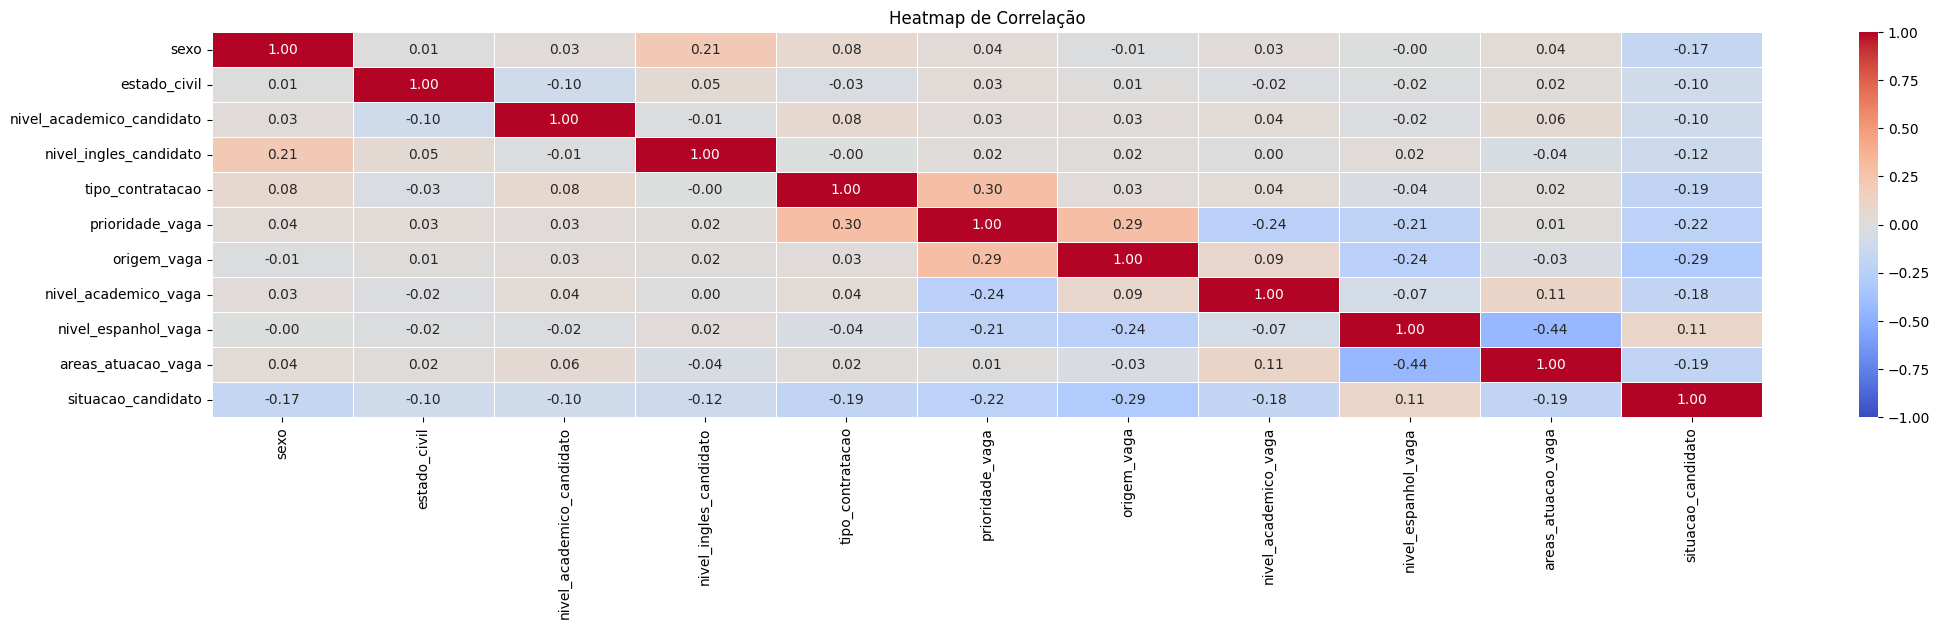

In [48]:

# Calcula a correla√ß√£o
correlation_matrix = df.corr()

# Ajusta o tamanho da figura
plt.figure(figsize=(25, 5))

# Cria o heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)

# T√≠tulo
plt.title("Heatmap de Correla√ß√£o")

# Exibir o gr√°fico
plt.show()

In [49]:
df.corr()["situacao_candidato"]

sexo                        -0.171333
estado_civil                -0.099637
nivel_academico_candidato   -0.099443
nivel_ingles_candidato      -0.119927
tipo_contratacao            -0.193320
prioridade_vaga             -0.222485
origem_vaga                 -0.289237
nivel_academico_vaga        -0.178465
nivel_espanhol_vaga          0.109070
areas_atuacao_vaga          -0.190531
situacao_candidato           1.000000
Name: situacao_candidato, dtype: float64

In [50]:
"""Em geral:
Correla√ß√£o forte: |r| ‚â• 0.5
Correla√ß√£o moderada: 0.3 ‚â§ |r| < 0.5
Correla√ß√£o fraca: |r| < 0.3"""

'Em geral:\nCorrela√ß√£o forte: |r| ‚â• 0.5\nCorrela√ß√£o moderada: 0.3 ‚â§ |r| < 0.5\nCorrela√ß√£o fraca: |r| < 0.3'

Treinamento do modelo

2025/05/02 02:12:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID ae5828b7579f427e8a3382fb7c0b1ba5. Failed operations: [RestException("INVALID_PARAMETER_VALUE: Changing param values is not allowed. Params were already logged=\'[{\'key\': \'random_state\', \'old_value\': \'42\', \'new_value\': \'None\'}]\' for run ID=\'ae5828b7579f427e8a3382fb7c0b1ba5\'.")]')]


Acur√°cia: 73.26%


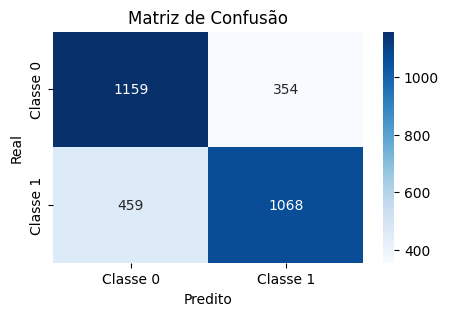

Relat√≥rio de Classifica√ß√£o:
              precision    recall  f1-score   support

           0       0.72      0.77      0.74      1513
           1       0.75      0.70      0.72      1527

    accuracy                           0.73      3040
   macro avg       0.73      0.73      0.73      3040
weighted avg       0.73      0.73      0.73      3040

üèÉ View run invincible-newt-962 at: http://localhost:5000/#/experiments/1/runs/ae5828b7579f427e8a3382fb7c0b1ba5
üß™ View experiment at: http://localhost:5000/#/experiments/1


In [51]:

# Divis√£o entre dados de treino e teste (80% treino, 20% teste)
import mlflow.sklearn

with mlflow.start_run():

    mlflow.sklearn.autolog()

    _random_state = 42
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=_random_state)

    mlflow.log_param("random_state", _random_state)


    # Instancia o modelo de Regress√£o Log√≠stica
    model = LogisticRegression(max_iter=1000, penalty=None)

    # Treina o modelo com os dados de treino
    model.fit(X_train, y_train)

    # Realiza previs√µes nos dados de teste
    y_pred = model.predict(X_test)

    # Avalia o desempenho do modelo
    accuracy = accuracy_score(y_test, y_pred) * 100  # Acur√°cia em porcentagem
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Exibe a acur√°cia em porcentagem
    print(f'Acur√°cia: {accuracy:.2f}%')

    # Exibe a Matriz de Confus√£o como um Heatmap
    plt.figure(figsize=(5, 3))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
    plt.title('Matriz de Confus√£o')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.show()

    # Relat√≥rio de Classifica√ß√£o
    print(f'Relat√≥rio de Classifica√ß√£o:\n{classification_report(y_test, y_pred)}')

Acur√°cia: 93.06%
Relat√≥rio de Classifica√ß√£o:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93      1513
           1       0.94      0.92      0.93      1527

    accuracy                           0.93      3040
   macro avg       0.93      0.93      0.93      3040
weighted avg       0.93      0.93      0.93      3040



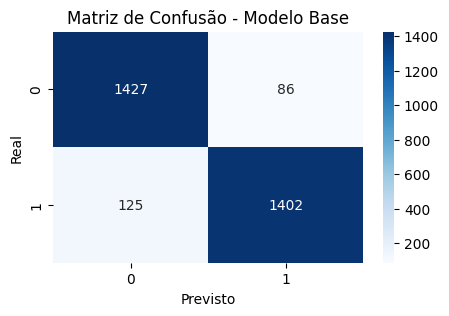

Fitting 3 folds for each of 48 candidates, totalling 144 fits


2025/05/02 02:13:22 INFO mlflow.sklearn.utils: Logging the 5 best runs, 43 runs will be omitted.


üèÉ View run exultant-crab-278 at: http://localhost:5000/#/experiments/1/runs/832a6986c787447db94acbe99a09394c
üß™ View experiment at: http://localhost:5000/#/experiments/1
üèÉ View run gentle-smelt-409 at: http://localhost:5000/#/experiments/1/runs/5b37c30bff2e47fa804502ab62d0abdb
üß™ View experiment at: http://localhost:5000/#/experiments/1
üèÉ View run trusting-fly-105 at: http://localhost:5000/#/experiments/1/runs/736e671a6fe9402c85f65343fc5e6d3a
üß™ View experiment at: http://localhost:5000/#/experiments/1
üèÉ View run melodic-dog-230 at: http://localhost:5000/#/experiments/1/runs/e1791d2af198459483ef2f308aac551c
üß™ View experiment at: http://localhost:5000/#/experiments/1
üèÉ View run amazing-frog-907 at: http://localhost:5000/#/experiments/1/runs/36634fe4a55e47558aa9462109746aad
üß™ View experiment at: http://localhost:5000/#/experiments/1
Melhores hiperpar√¢metros: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 200}
Melhor acur√°cia (valida√ß√£o cruzada): 93.

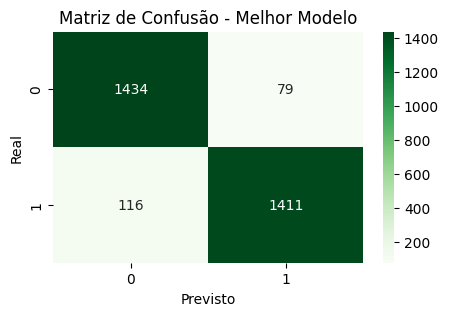

2025/05/02 02:13:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


üèÉ View run sedate-hound-471 at: http://localhost:5000/#/experiments/1/runs/d0dc74721b1f4d6080ca408c8c02e729
üß™ View experiment at: http://localhost:5000/#/experiments/1


In [52]:
import boto3

# üîπ Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

with mlflow.start_run():
        
    # üîπ Criando e treinando o modelo XGBoost
    model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
    model.fit(X_train, y_train)

    # üîπ Fazendo previs√µes
    y_pred = model.predict(X_test)

    # üîπ Avalia√ß√£o do modelo
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"Acur√°cia: {accuracy:.2%}")
    print("Relat√≥rio de Classifica√ß√£o:\n", report)

    # üîπ Matriz de confus√£o
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 3))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.title("Matriz de Confus√£o - Modelo Base")
    plt.show()

    # üîπ Ajuste de hiperpar√¢metros com GridSearchCV
    param_grid = {
        'n_estimators': [100, 150, 200],
        'max_depth': [3, 5, 7, 11],
        'learning_rate': [0.01, 0.1, 0.3, 0.4]
    }

    grid_search = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric="logloss"), 
                            param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

    grid_search.fit(X_train, y_train)

    # üîπ Melhor modelo encontrado
    best_model = grid_search.best_estimator_
    best_accuracy = grid_search.best_score_

    print(f"Melhores hiperpar√¢metros: {grid_search.best_params_}")
    print(f"Melhor acur√°cia (valida√ß√£o cruzada): {best_accuracy:.2%}")

    # üîπ Avalia√ß√£o no conjunto de teste
    y_pred_best = best_model.predict(X_test)
    print("Relat√≥rio de Classifica√ß√£o (Melhor Modelo):\n", classification_report(y_test, y_pred_best))

    # üîπ Matriz de confus√£o do melhor modelo
    conf_matrix_best = confusion_matrix(y_test, y_pred_best)
    plt.figure(figsize=(5, 3))
    sns.heatmap(conf_matrix_best, annot=True, fmt="d", cmap="Greens", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.title("Matriz de Confus√£o - Melhor Modelo")
    plt.show()
    
    # Salva artefato modelo.
    mlflow.sklearn.log_model(best_model, "modelo_xgboost.joblib")



In [53]:
# a acur√°cia do modelo melhorou muito. Precision, recall e f1-score est√£o bem equilibrados, ent√£o o modelo j√° est√° √≥timo

Valida√ß√£o do modelo

Acur√°cia no conjunto de valida√ß√£o: 93.59%
Relat√≥rio de Classifica√ß√£o:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      1513
           1       0.95      0.92      0.94      1527

    accuracy                           0.94      3040
   macro avg       0.94      0.94      0.94      3040
weighted avg       0.94      0.94      0.94      3040



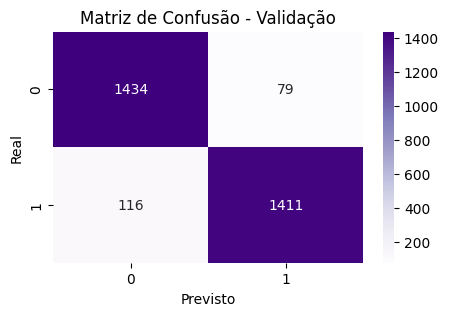

In [54]:


# üîπ Fazer previs√µes no conjunto de valida√ß√£o
y_val_pred = best_model.predict(X_test)

# üîπ Avaliar desempenho
accuracy = accuracy_score(y_test, y_val_pred)
print(f"Acur√°cia no conjunto de valida√ß√£o: {accuracy:.2%}")

print("Relat√≥rio de Classifica√ß√£o:\n", classification_report(y_test, y_val_pred))

# üîπ Matriz de Confus√£o

conf_matrix = confusion_matrix(y_test, y_val_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confus√£o - Valida√ß√£o")
plt.show()

In [55]:
# Acur√°cia no conjunto de valida√ß√£o est√° praticamente id√™ntica √† do treino , indicando que o modelo n√£o est√° overfittado e generaliza bem

In [56]:

cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')
print(f"Acur√°cia M√©dia (Cross Validation): {cv_scores.mean():.2%}")
print(f"Desvio Padr√£o: {cv_scores.std():.2%}")

Acur√°cia M√©dia (Cross Validation): 90.89%
Desvio Padr√£o: 3.71%


In [57]:
# A acur√°cia m√©dia no Cross Validation √© boa, mas um pouco menor do que no conjunto de teste
# O desvio padr√£o sugere uma varia√ß√£o razo√°vel entre os folds. Isso significa que o modelo pode estar sofrendo um pouco de sensibilidade aos dados de treino.

In [58]:
# Identificar exemplos que o modelo previu errado
erros = X_test[y_test != y_val_pred]
erros.head()

sexo  nivel_ingles_candidato  tipo_contratacao  prioridade_vaga  \
7934  0.601274               -0.707633          1.409603         0.593743   
4295  0.601274                1.292123         -0.835397        -0.191987   
3881  0.601274               -0.707633         -0.835397         0.593743   
5228 -2.774300                1.292123         -0.835397        -1.763447   
3941  0.601274                1.292123          1.409603         0.593743   

      origem_vaga  nivel_profissional_vaga  nivel_academico_vaga  \
7934      1.34064                 0.396429              0.885399   
4295     -1.17337                 0.396429              0.885399   
3881     -1.17337                -0.987839             -1.007969   
5228     -1.17337                -0.987839             -1.007969   
3941      1.34064                 0.396429             -1.007969   

      nivel_ingles_vaga  nivel_espanhol_vaga  areas_atuacao_vaga  
7934           0.067902            -0.971418            0.966888  
4295           0.067902            -0.971418           -0.084586  
3881           0.067902             0.936358            0.843186  
5228           0.067902             0.936358           -0.146437  
3941           0.067902            -0.971418            0.657631

In [59]:
# O modelo j√° est√° bem testado e validado
# ‚úî Acur√°cia alta e est√°vel ‚Üí no conjunto de valida√ß√£o e no Cross Validation.
# ‚úî Sem overfitting grave ‚Üí Pequena diferen√ßa entre treino e teste, sem queda brusca de performance.
# ‚úî Cross Validation feito ‚Üí O modelo foi avaliado em diferentes amostras dos dados.
# ‚úî Relat√≥rios de classifica√ß√£o analisados ‚Üí Precision, Recall e F1-score equilibrados.
# ‚úî Matriz de confus√£o revisada ‚Üí Nenhuma distor√ß√£o grave na previs√£o das classes.

In [60]:

# üîπ Salvando o modelo
joblib.dump(best_model, "modelo_xgboost.joblib")



# üîπ Carregando o modelo posteriormente
modelo_carregado = joblib.load("modelo_xgboost.joblib")

# Teste de carregamento
print(modelo_carregado.predict(X_test[:5]))

[0 0 0 1 0]
